**Run the following two cells before you begin.**

In [1]:
%autosave 10

Autosaving every 10 seconds


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('cleaned_data.csv')

**Run the following 3 cells to create a list of features, create a train/test split, and instantiate a random forest classifier.**

In [3]:
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[features_response[:-1]].values,
    df['default payment next month'].values,
    test_size=0.2, random_state=24
)

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10, criterion='gini', max_depth=3,
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
    max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
    min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
    random_state=4, verbose=0, warm_start=False, class_weight=None
)

**Create a dictionary representing the grid for the `max_depth` and `n_estimators` hyperparameters that will be searched. Include depths of 3, 6, 9, and 12, and 10, 50, 100, and 200 trees.**

In [6]:
rf_params = {'max_depth':[3, 6, 9, 12],'n_estimators':[10, 50, 100, 200]}

________________________________________________________________
**Instantiate a `GridSearchCV` object using the same options that we have previously in this course, but with the dictionary of hyperparameters created above. Set `verbose=2` to see the output for each fit performed.**

In [7]:
from sklearn.model_selection import GridSearchCV

cv_rf = GridSearchCV(rf, param_grid=rf_params, scoring='roc_auc',n_jobs=-1, refit=True, cv=4, verbose=2,error_score=np.nan, return_train_score=True)

____________________________________________________
**Fit the `GridSearchCV` object on the training data.**

In [16]:
cv_rf.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  1.8min finished


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=2)

___________________________________________________________
**Put the results of the grid search in a pandas DataFrame.**

In [17]:
cv_rf_results_df = pd.DataFrame(cv_rf.cv_results_)

**Find the best hyperparameters from the cross-validation.**

In [18]:
cv_rf_results_df.max()

mean_fit_time          18.421191
std_fit_time            0.097826
mean_score_time         0.396023
std_score_time          0.028272
param_max_depth        12.000000
param_n_estimators    200.000000
split0_test_score       0.765910
split1_test_score       0.767541
split2_test_score       0.790255
split3_test_score       0.783513
mean_test_score         0.776199
std_test_score          0.014656
rank_test_score        16.000000
split0_train_score      0.945018
split1_train_score      0.949378
split2_train_score      0.946415
split3_train_score      0.944689
mean_train_score        0.946375
std_train_score         0.004263
dtype: float64

________________________________________________________________________________________________________
**Create a `pcolormesh` visualization of the mean testing score for each combination of hyperparameters.**

<details>
    <summary>Hint:</summary>
    Remember to reshape the values of the mean testing scores to be a two-dimensional 4x4 grid.
</details>

In [19]:
# Create a 5x5 grid
xx_rf, yy_rf = np.meshgrid(range(5), range(5))


In [20]:
# Set color map to `plt.cm.jet`
cm_rf = plt.cm.jet


Text(0, 0.5, 'Maximum depth')

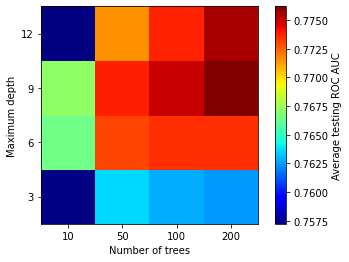

In [21]:
# Visualize pcolormesh
ax_rf = plt.axes()
pcolor_graph = ax_rf.pcolormesh(xx_rf, yy_rf, cv_rf_results_df['mean_test_score'].values.reshape((4,4)), cmap=cm_rf)
plt.colorbar(pcolor_graph, label='Average testing ROC AUC')
ax_rf.set_aspect('equal')
ax_rf.set_xticks([0.5, 1.5, 2.5, 3.5])
ax_rf.set_yticks([0.5, 1.5, 2.5, 3.5])
ax_rf.set_xticklabels([str(tick_label) for tick_label in rf_params['n_estimators']])
ax_rf.set_yticklabels([str(tick_label) for tick_label in rf_params['max_depth']])
ax_rf.set_xlabel('Number of trees')
ax_rf.set_ylabel('Maximum depth')

________________________________________________________________________________________________________
**Conclude which set of hyperparameters to use.**

In [22]:
# Create a dataframe of the feature names and importance
feat_imp_df_act = pd.DataFrame({'Feature name':features_response[:-1],'Importance':cv_rf.best_estimator_.feature_importances_})


In [23]:
# Sort values by importance
feat_imp_df_act.sort_values('Importance', ascending=False)


,Feature name,Importance
4,PAY_1,0.437439
0,LIMIT_BAL,0.059961
11,PAY_AMT1,0.059434
12,PAY_AMT2,0.045518
13,PAY_AMT3,0.043299
5,BILL_AMT1,0.042195
6,BILL_AMT2,0.041562
7,BILL_AMT3,0.037268
14,PAY_AMT4,0.034321
8,BILL_AMT4,0.034123


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021255816BB0>]],
      dtype=object)

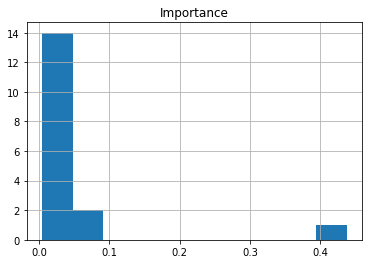

In [24]:
feat_imp_df_act.hist()